In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn

from trainer import Trainer

### Utility Functions

In [2]:
def get_device():
    """Get available device"""

    if torch.cuda.is_available():
        print("Using CUDA...")
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("Using MPS...")
        return torch.device("mps")
    else:
        print("Using CPU...")
        return torch.device("cpu")

def imshow(img):
    """Display CIFAR10 image"""
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# setup device
device = get_device()

Using MPS...


### Load CIFAR-10 dataset

In [4]:
BATCH_SIZE = 256

train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)

# split into 80-20 train and validation dataset
train_set, val_set = torch.utils.data.random_split(train_set, [0.90, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Input Tensor: torch.Size([3, 32, 32])
Label: 2


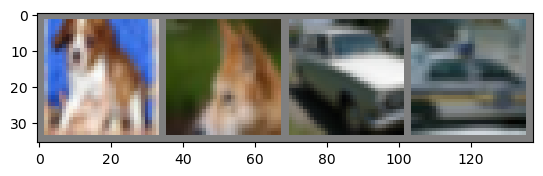

dog   dog   car   car  


In [5]:
# get one sample
images, labels = train_set[0]

print(f"Input Tensor: {images.shape}")
print(f"Label: {labels}")

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Training Existing ResNet-18 Model
We will call PyTorch's existing implementation the baseline model

In [6]:
baseline_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# drop last linear layer and fit new linear layer for CIFAR-10
baseline_net.fc = nn.Linear(in_features=512, out_features=10)
baseline_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
# setup trainer class to fine-tune ResNet-18
baseline_trainer = Trainer(baseline_net, model_name="baseline_pytorch_resnet18", batch_size=BATCH_SIZE, device=device)
baseline_trainer.train(train_dataloader, val_dataloader)

100%|██████████| 176/176 [00:36<00:00,  4.84it/s, loss=1.07]


INFO | [EPOCH 1] LOSS : train=1.286272436719049 val=1.08489148914814 | ACCURACY : train=0.5479474663734436 val=0.6259650588035583


100%|██████████| 176/176 [00:26<00:00,  6.72it/s, loss=0.932]


INFO | [EPOCH 2] LOSS : train=0.990306284617294 val=0.9550581574440002 | ACCURACY : train=0.6530948281288147 val=0.6613855957984924


100%|██████████| 176/176 [00:27<00:00,  6.37it/s, loss=0.887]


INFO | [EPOCH 3] LOSS : train=0.9040307229892774 val=0.8706184923648834 | ACCURACY : train=0.684182345867157 val=0.6992992162704468


100%|██████████| 176/176 [00:28<00:00,  6.27it/s, loss=0.793]


INFO | [EPOCH 4] LOSS : train=0.8471124080771749 val=0.8968989551067352 | ACCURACY : train=0.7057741284370422 val=0.6943933963775635


100%|██████████| 176/176 [00:26<00:00,  6.74it/s, loss=0.824]


INFO | [EPOCH 5] LOSS : train=0.8158039420165799 val=0.8258894473314286 | ACCURACY : train=0.716583788394928 val=0.7140395045280457


100%|██████████| 176/176 [00:26<00:00,  6.66it/s, loss=0.784]


INFO | [EPOCH 6] LOSS : train=0.7839251492511142 val=0.8343735456466674 | ACCURACY : train=0.7263405323028564 val=0.7137293219566345


100%|██████████| 176/176 [00:29<00:00,  5.91it/s, loss=0.759]


INFO | [EPOCH 7] LOSS : train=0.762033720585433 val=0.7911557585000992 | ACCURACY : train=0.7335058450698853 val=0.7235983610153198


100%|██████████| 176/176 [00:31<00:00,  5.53it/s, loss=0.701]


INFO | [EPOCH 8] LOSS : train=0.6997166970236735 val=0.7243952184915543 | ACCURACY : train=0.7544931173324585 val=0.7460592985153198


100%|██████████| 176/176 [00:33<00:00,  5.25it/s, loss=0.641]


INFO | [EPOCH 9] LOSS : train=0.6711378073827787 val=0.7166051954030991 | ACCURACY : train=0.7646706104278564 val=0.7419692277908325


100%|██████████| 176/176 [00:32<00:00,  5.35it/s, loss=0.661]


INFO | [EPOCH 10] LOSS : train=0.6653870520266619 val=0.7056184530258178 | ACCURACY : train=0.7704395055770874 val=0.7584673762321472


100%|██████████| 176/176 [00:32<00:00,  5.34it/s, loss=0.661]


INFO | [EPOCH 11] LOSS : train=0.6553595441986214 val=0.6860603153705597 | ACCURACY : train=0.7713183760643005 val=0.7612591981887817


100%|██████████| 176/176 [00:33<00:00,  5.32it/s, loss=0.653]


INFO | [EPOCH 12] LOSS : train=0.6484900083054196 val=0.7064913958311081 | ACCURACY : train=0.7744637131690979 val=0.7642577886581421


100%|██████████| 176/176 [00:32<00:00,  5.39it/s, loss=0.616]


INFO | [EPOCH 13] LOSS : train=0.6454037690365856 val=0.7014262497425079 | ACCURACY : train=0.7754057049751282 val=0.7570542097091675


100%|██████████| 176/176 [00:32<00:00,  5.35it/s, loss=0.663]


INFO | [EPOCH 14] LOSS : train=0.6384070774709637 val=0.6886928468942642 | ACCURACY : train=0.7772132754325867 val=0.7610523700714111


100%|██████████| 176/176 [00:32<00:00,  5.36it/s, loss=0.627]


INFO | [EPOCH 15] LOSS : train=0.6348726751113479 val=0.69110586643219 | ACCURACY : train=0.7790296673774719 val=0.7594324350357056


100%|██████████| 176/176 [00:32<00:00,  5.38it/s, loss=0.619]


INFO | [EPOCH 16] LOSS : train=0.6292329994453625 val=0.6761854141950607 | ACCURACY : train=0.7796884179115295 val=0.767417311668396


100%|██████████| 176/176 [00:33<00:00,  5.27it/s, loss=0.62] 


INFO | [EPOCH 17] LOSS : train=0.6296692885119807 val=0.6777697026729583 | ACCURACY : train=0.7814577221870422 val=0.7622587084770203


100%|██████████| 176/176 [00:33<00:00,  5.24it/s, loss=0.634]


INFO | [EPOCH 18] LOSS : train=0.6276818612082438 val=0.6889997512102127 | ACCURACY : train=0.7808433771133423 val=0.7648207545280457


100%|██████████| 176/176 [00:33<00:00,  5.25it/s, loss=0.621]


INFO | [EPOCH 19] LOSS : train=0.6249822351065549 val=0.6859894335269928 | ACCURACY : train=0.7811861038208008 val=0.7629250884056091


100%|██████████| 176/176 [00:33<00:00,  5.26it/s, loss=0.631]


INFO | [EPOCH 20] LOSS : train=0.6244174028662118 val=0.693926876783371 | ACCURACY : train=0.781193196773529 val=0.7543543577194214


100%|██████████| 176/176 [00:33<00:00,  5.32it/s, loss=0.654]


INFO | [EPOCH 21] LOSS : train=0.6255777488377962 val=0.6961856931447983 | ACCURACY : train=0.7827014923095703 val=0.767417311668396


100%|██████████| 176/176 [00:33<00:00,  5.29it/s, loss=0.633]


INFO | [EPOCH 22] LOSS : train=0.6212000799450007 val=0.7064814060926438 | ACCURACY : train=0.7841193675994873 val=0.7543888092041016


100%|██████████| 176/176 [00:32<00:00,  5.35it/s, loss=0.618]


INFO | [EPOCH 23] LOSS : train=0.6282631067389791 val=0.6763187676668168 | ACCURACY : train=0.7809375524520874 val=0.7652343511581421


100%|██████████| 176/176 [00:30<00:00,  5.70it/s, loss=0.626]


INFO | [EPOCH 24] LOSS : train=0.6277586677196351 val=0.679685378074646 | ACCURACY : train=0.7804012894630432 val=0.761914074420929


100%|██████████| 176/176 [00:32<00:00,  5.47it/s, loss=0.636]


INFO | [EPOCH 25] LOSS : train=0.6347023956477642 val=0.6839278846979141 | ACCURACY : train=0.7786825299263 val=0.7646369338035583


100%|██████████| 176/176 [00:32<00:00,  5.35it/s, loss=0.627]


INFO | [EPOCH 26] LOSS : train=0.6306528110395778 val=0.6711541086435318 | ACCURACY : train=0.7782323956489563 val=0.7686580419540405


100%|██████████| 176/176 [00:32<00:00,  5.34it/s, loss=0.628]


INFO | [EPOCH 27] LOSS : train=0.627986172891476 val=0.6675880074501037 | ACCURACY : train=0.7795019149780273 val=0.7618451118469238


100%|██████████| 176/176 [00:31<00:00,  5.61it/s, loss=0.631]


INFO | [EPOCH 28] LOSS : train=0.6285530110313133 val=0.6925400286912918 | ACCURACY : train=0.7814426422119141 val=0.7614774703979492


100%|██████████| 176/176 [00:30<00:00,  5.70it/s, loss=0.63] 


INFO | [EPOCH 29] LOSS : train=0.6280964213338766 val=0.6929173588752746 | ACCURACY : train=0.7831888794898987 val=0.7614315152168274


100%|██████████| 176/176 [00:31<00:00,  5.67it/s, loss=0.626]


INFO | [EPOCH 30] LOSS : train=0.6242200828750025 val=0.6750830501317978 | ACCURACY : train=0.7813707590103149 val=0.7666475176811218


INFO | Test accuracy: 82.783203125 %


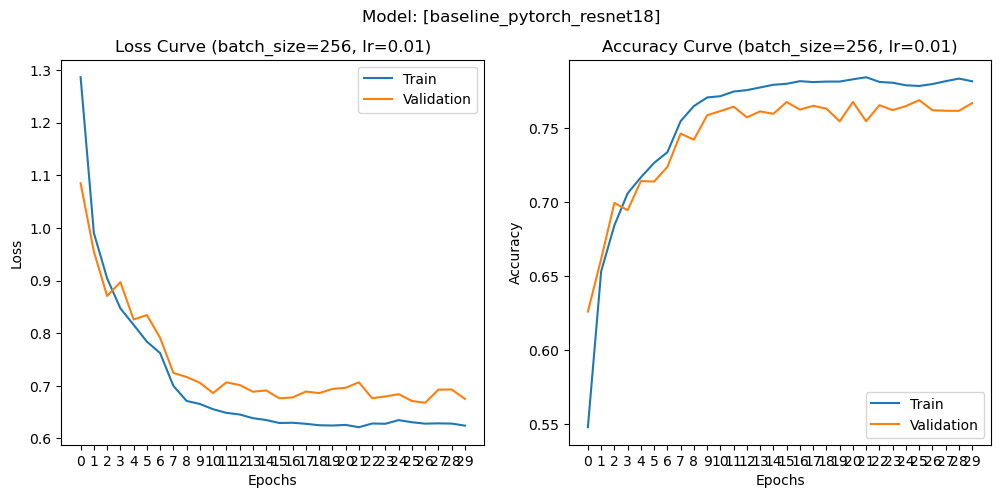

In [8]:
baseline_trainer.test(test_dataloader)
baseline_trainer.plot_metrics()

### Training My PyTorch Implementation of ResNet-18

In [9]:
from resnet18 import ResNet18

resnet = ResNet18.from_pretrained("resnet18")
print("lfg, we didn't crash!")
resnet_trainer = Trainer(resnet, device=device)
resnet_trainer.train(train_dataloader, val_dataloader)

loading weights from pytorch pretrained resnet18
lfg, we didn't crash!


100%|██████████| 176/176 [00:30<00:00,  5.75it/s, loss=1.06]


INFO | [EPOCH 1] LOSS : train=1.2987082800404592 val=1.066767728328705 | ACCURACY : train=0.5436567664146423 val=0.6307330131530762


100%|██████████| 176/176 [00:31<00:00,  5.52it/s, loss=0.958]


INFO | [EPOCH 2] LOSS : train=0.9910383884879675 val=0.9817789405584335 | ACCURACY : train=0.654515266418457 val=0.6531479954719543


100%|██████████| 176/176 [00:33<00:00,  5.28it/s, loss=0.902]


INFO | [EPOCH 3] LOSS : train=0.9025072634897449 val=0.9234665036201477 | ACCURACY : train=0.6883513927459717 val=0.6737591624259949


100%|██████████| 176/176 [00:32<00:00,  5.48it/s, loss=0.826]


INFO | [EPOCH 4] LOSS : train=0.848715050315315 val=0.8729105591773987 | ACCURACY : train=0.7037908434867859 val=0.7011603713035583


100%|██████████| 176/176 [00:32<00:00,  5.44it/s, loss=0.779]


INFO | [EPOCH 5] LOSS : train=0.8222644034434449 val=0.8484807193279267 | ACCURACY : train=0.7149884700775146 val=0.7070542573928833


100%|██████████| 176/176 [00:32<00:00,  5.45it/s, loss=0.753]


INFO | [EPOCH 6] LOSS : train=0.7823036861690608 val=0.8243457168340683 | ACCURACY : train=0.726318359375 val=0.716521143913269


100%|██████████| 176/176 [00:32<00:00,  5.45it/s, loss=0.757]


INFO | [EPOCH 7] LOSS : train=0.7655492143874819 val=0.7792590349912644 | ACCURACY : train=0.7336469888687134 val=0.7319278717041016


100%|██████████| 176/176 [00:32<00:00,  5.36it/s, loss=0.691]


INFO | [EPOCH 8] LOSS : train=0.6995577104389668 val=0.7575578153133392 | ACCURACY : train=0.7554207444190979 val=0.7411075830459595


100%|██████████| 176/176 [00:33<00:00,  5.28it/s, loss=0.665]


INFO | [EPOCH 9] LOSS : train=0.677350561727177 val=0.7283627033233643 | ACCURACY : train=0.7624156475067139 val=0.7452435493469238


100%|██████████| 176/176 [00:32<00:00,  5.39it/s, loss=0.644]


INFO | [EPOCH 10] LOSS : train=0.6689682836559686 val=0.7037377685308457 | ACCURACY : train=0.7666202187538147 val=0.7583295106887817


100%|██████████| 176/176 [00:32<00:00,  5.46it/s, loss=0.63] 


INFO | [EPOCH 11] LOSS : train=0.6578857031735507 val=0.6976832687854767 | ACCURACY : train=0.7703319787979126 val=0.7591911554336548


100%|██████████| 176/176 [00:32<00:00,  5.39it/s, loss=0.656]


INFO | [EPOCH 12] LOSS : train=0.6576853714544665 val=0.7130735039710998 | ACCURACY : train=0.7698926329612732 val=0.7527114152908325


100%|██████████| 176/176 [00:31<00:00,  5.50it/s, loss=0.64] 


INFO | [EPOCH 13] LOSS : train=0.6490870480510321 val=0.6877649843692779 | ACCURACY : train=0.7748304605484009 val=0.7693129777908325


100%|██████████| 176/176 [00:33<00:00,  5.31it/s, loss=0.646]


INFO | [EPOCH 14] LOSS : train=0.638422195206989 val=0.6998100310564042 | ACCURACY : train=0.7765562534332275 val=0.7646139860153198


100%|██████████| 176/176 [00:32<00:00,  5.42it/s, loss=0.63] 


INFO | [EPOCH 15] LOSS : train=0.6308240990408442 val=0.6805550485849381 | ACCURACY : train=0.7808913588523865 val=0.7620174288749695


100%|██████████| 176/176 [00:32<00:00,  5.39it/s, loss=0.664]


INFO | [EPOCH 16] LOSS : train=0.6366010658781637 val=0.6732131510972976 | ACCURACY : train=0.7765190005302429 val=0.767417311668396


100%|██████████| 176/176 [00:31<00:00,  5.59it/s, loss=0.643]


INFO | [EPOCH 17] LOSS : train=0.6259037080136213 val=0.6878178149461747 | ACCURACY : train=0.7790651321411133 val=0.7631893157958984


100%|██████████| 176/176 [00:33<00:00,  5.28it/s, loss=0.624]


INFO | [EPOCH 18] LOSS : train=0.6334158449687741 val=0.6894718319177627 | ACCURACY : train=0.7781293988227844 val=0.7591107487678528


100%|██████████| 176/176 [00:33<00:00,  5.19it/s, loss=0.665]


INFO | [EPOCH 19] LOSS : train=0.6297842775556174 val=0.6686183601617813 | ACCURACY : train=0.7790998220443726 val=0.767578125


100%|██████████| 176/176 [00:32<00:00,  5.41it/s, loss=0.611]


INFO | [EPOCH 20] LOSS : train=0.6268090631135486 val=0.7095408082008362 | ACCURACY : train=0.7807510495185852 val=0.7569049000740051


100%|██████████| 176/176 [00:31<00:00,  5.65it/s, loss=0.632]


INFO | [EPOCH 21] LOSS : train=0.6311318921771917 val=0.6859600245952606 | ACCURACY : train=0.7794353365898132 val=0.7627183198928833


100%|██████████| 176/176 [00:31<00:00,  5.53it/s, loss=0.643]


INFO | [EPOCH 22] LOSS : train=0.6228244111619212 val=0.6873161405324936 | ACCURACY : train=0.7812721729278564 val=0.7598345875740051


100%|██████████| 176/176 [00:31<00:00,  5.65it/s, loss=0.604]


INFO | [EPOCH 23] LOSS : train=0.6315269954502583 val=0.6930732190608978 | ACCURACY : train=0.7772886753082275 val=0.7568359375


100%|██████████| 176/176 [00:31<00:00,  5.64it/s, loss=0.666]


INFO | [EPOCH 24] LOSS : train=0.6320237544449893 val=0.6802729219198227 | ACCURACY : train=0.7789382338523865 val=0.7685087323188782


100%|██████████| 176/176 [00:32<00:00,  5.41it/s, loss=0.638]


INFO | [EPOCH 25] LOSS : train=0.6297353822737932 val=0.7008555948734283 | ACCURACY : train=0.7791850566864014 val=0.7576976418495178


100%|██████████| 176/176 [00:31<00:00,  5.63it/s, loss=0.653]


INFO | [EPOCH 26] LOSS : train=0.6345537682487206 val=0.6720208168029785 | ACCURACY : train=0.7777051329612732 val=0.768715500831604


100%|██████████| 176/176 [00:33<00:00,  5.28it/s, loss=0.62] 


INFO | [EPOCH 27] LOSS : train=0.6308871734548699 val=0.6927421003580093 | ACCURACY : train=0.7791796326637268 val=0.756640613079071


100%|██████████| 176/176 [00:32<00:00,  5.40it/s, loss=0.666]


INFO | [EPOCH 28] LOSS : train=0.6268047548153184 val=0.6865397334098816 | ACCURACY : train=0.7807288765907288 val=0.7675091624259949


100%|██████████| 176/176 [00:31<00:00,  5.61it/s, loss=0.616]


INFO | [EPOCH 29] LOSS : train=0.6288474613631313 val=0.6829144835472107 | ACCURACY : train=0.7807803750038147 val=0.7661190032958984


100%|██████████| 176/176 [00:32<00:00,  5.36it/s, loss=0.618]


INFO | [EPOCH 30] LOSS : train=0.6313404390080408 val=0.6848244786262512 | ACCURACY : train=0.7778471112251282 val=0.7669922113418579


INFO | Test accuracy: 82.83203125 %


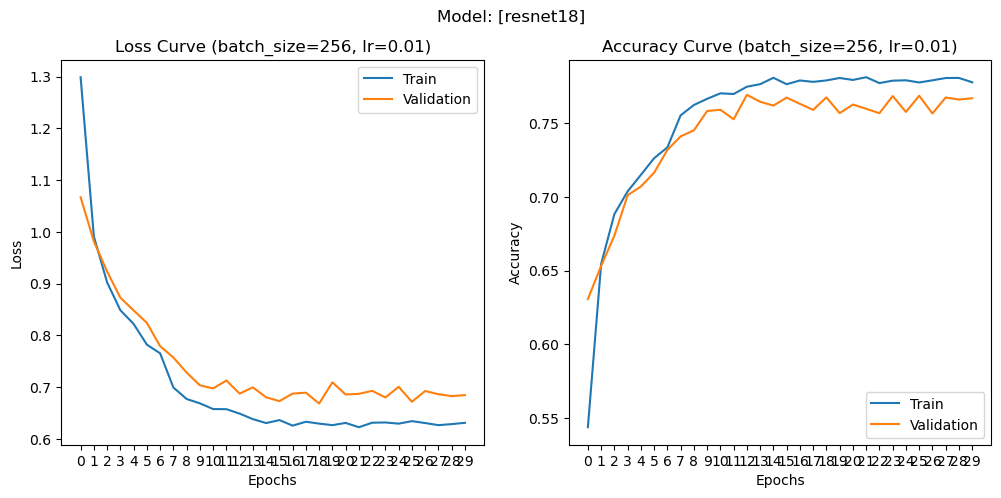

In [10]:
resnet_trainer.test(test_dataloader)
resnet_trainer.plot_metrics()

# Acknowledgements

- [PyTorch CIFAR10 Training Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [A Detailed Introduction to ResNet and Its Implementation in PyTorch](https://medium.com/@freshtechyy/a-detailed-introduction-to-resnet-and-its-implementation-in-pytorch-744b13c8074a) by Huili Yu
- [Let's reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU) by Andrej Karpathy
- [Helpful conventions for PyTorch model building](https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md) by FrancescoSaverioZuppichini  